In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [13]:
batch = 32
channels = 3
height = 32
width = 64

ground_truth = torch.zeros(batch, channels, height, width)
forecast_means = torch.rand_like(ground_truth)
forecast_stds = torch.ones(batch, channels, height, width)
forecast_stds += torch.rand_like(forecast_stds)

In [14]:
ensemble_size = 50
all_mean_rank = torch.empty((batch, channels))

# Get mean rank across all samples in the batch
for i in range(batch):
    
    # Generate the ensemble forecast
    ensemble_forecast = torch.empty((ensemble_size, channels, height, width))
    for j in range(ensemble_size):
        for k in range(channels):
            indiv_forecast = torch.normal(forecast_means[i,k], forecast_stds[i,k])
            ensemble_forecast[j,k] = indiv_forecast

    # Get the mean rank per channel
    mean_rank = torch.empty((channels))
    for j in range(channels):
        concat_forecast = torch.concatenate((
            ensemble_forecast[:,j],
            ground_truth[i,j].unsqueeze(0))
        )
        sorted_forecast, _ = torch.sort(concat_forecast, dim=0)
        rank = (sorted_forecast == ground_truth[i,j]).nonzero()[:,0]
        mean_rank[j] = rank.to(float).mean()
        
    all_mean_rank[i] = mean_rank

In [15]:
all_mean_rank.shape

torch.Size([32, 3])

In [16]:
torch.concatenate((all_mean_rank, all_mean_rank)).shape

torch.Size([64, 3])

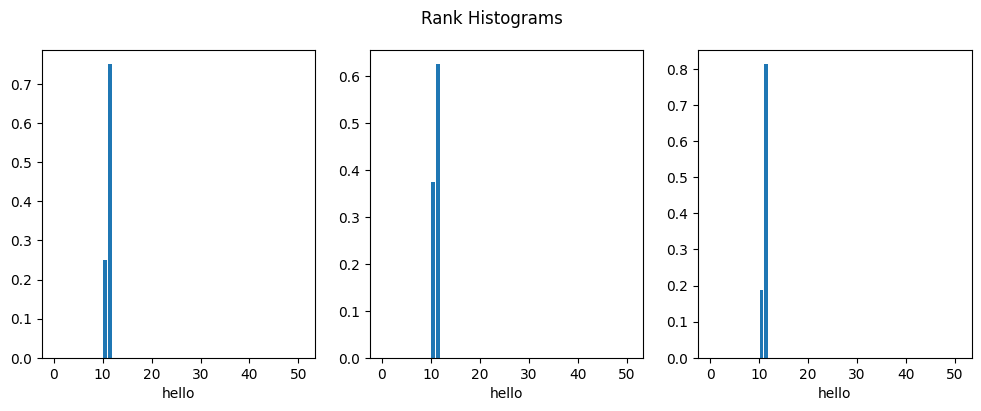

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
bins = torch.arange(-0.5, ensemble_size+1.5, 1)

for i in range(channels):
    freq, _ = np.histogram(all_mean_rank[:,i], bins=bins)
    rel_freq = freq / np.sum(freq)
    ax[i].bar(bins[1:], rel_freq)
    ax[i].set_xlabel("hello")
    
fig.suptitle("Rank Histograms")
plt.show()